In [6]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
import time
from functools import wraps

def measure_execution_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {execution_time:.4f} seconds")
        return result
    return wrapper

In [8]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

class Model():
    def __init__(self, hyperparameters):
        self.hyperparameters = hyperparameters

    def load_data(self):
        """
        Data from: https://www.kaggle.com/code/stefanbergstein/keras-deep-learning-on-titanic-data
        """
        data = pd.read_csv('dataset/train.csv')
        # Fill missing values
        # Fill numerical columns with the median value
        data['Age'] = data['Age'].fillna(data['Age'].median())
        data['Fare'] = data['Fare'].fillna(data['Fare'].median())
        data['Sex'] = data['Sex'].fillna(data['Sex'].mode()[0])
        data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

        variables = ['Pclass','Sex', 'Age','Parch','SibSp','Embarked']
        x = data[variables]
        y = data[['Survived']]

        le = LabelEncoder()
        x.loc[:, 'Sex'] = le.fit_transform(x['Sex'])
        x.loc[:, 'Embarked'] = le.fit_transform(x['Embarked'])

        scaler = StandardScaler()
        x = x.astype('float64')
        x.loc[:, variables] = scaler.fit_transform(x[variables]).astype('float64')

        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(x, y, test_size=0.2, random_state=42)

        return self.x_train, self.y_train

    def build_model(self):
        input_layer = tf.keras.layers.Input(shape=(self.x_train.shape[1],))

        dense = tf.keras.layers.Dense(self.hyperparameters['neurons_per_layer'], activation = 'relu', kernel_initializer = 'he_normal')(input_layer)
        for _ in range(self.hyperparameters['num_layers'] - 1):
            dense = tf.keras.layers.Dense(self.hyperparameters['neurons_per_layer'], activation = 'relu', kernel_initializer = 'he_normal')(dense)
            if self.hyperparameters['dropout'] > 0:
                dense = tf.keras.layers.Dropout(self.hyperparameters['dropout'])(dense)

        output_layer = tf.keras.layers.Dense(1,activation = 'sigmoid')(dense)

        model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.hyperparameters['learning_rate'])
        model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

        self.model = model
        return model

    def train(self):
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)]
        self.score = self.model.fit(self.x_train, self.y_train, epochs=100, batch_size=self.hyperparameters['batch_size'],
                               validation_data=(self.x_val, self.y_val), callbacks=callbacks)

        return self.score

    def evaluate(self):
        """Evaluate the model on the validation set."""
        return self.model.evaluate(self.x_val, self.y_val)[1]

    def run(self):
        self.load_data()
        self.build_model()
        self.train()

In [ ]:
hyperparameters = {
    'learning_rate': 10**-4,
    'num_layers': 2,
    'neurons_per_layer': 64,
    'batch_size': 32,
    'dropout': 0.3,
}
model = Model(hyperparameters)
model.run()

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4149 - loss: 0.9356 - val_accuracy: 0.5307 - val_loss: 0.8154
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5247 - loss: 0.8498 - val_accuracy: 0.5475 - val_loss: 0.7655
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5213 - loss: 0.8014 - val_accuracy: 0.6369 - val_loss: 0.7213
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5421 - loss: 0.8124 - val_accuracy: 0.6425 - val_loss: 0.6835
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5977 - loss: 0.7644 - val_accuracy: 0.6425 - val_loss: 0.6510
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6104 - loss: 0.7132 - val_accuracy: 0.6480 - val_loss: 0.6237
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6381 - loss: 0.6698 - val_accuracy: 0.6760 - val_loss: 0.6001
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7088 - loss: 0.6263 - val_accuracy: 0.6927 - 

# Optmize

- Learning rate: 1e-6 an 1e-1
- Number of hidden Layers
- Batch Size
- Number of neurons
- Dropout Rate

In [9]:
class Evolution():
    def __init__(self, population_size, generations, mutation_rate, crossover_rate):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = []

    def initialize_population(self):
        """Initialize the population with random hyperparameter configurations."""
        for _ in range(self.population_size):
            individual = {
                'learning_rate': 10**random.uniform(-6, -1),
                'num_layers': random.randint(1, 5),
                'neurons_per_layer': random.choice([32, 64, 128, 256, 512]),
                'batch_size': random.choice([16, 32, 64, 128]),
                'dropout': random.uniform(0.1, 0.5),
            }
            self.population.append(individual)

    def evaluate_population(self, model_class: Model):
        """Evaluate the fitness of the population based on validation accuracy."""
        fitness_scores = []
        for individual in self.population:
            model = model_class(individual)
            model.load_data()
            model.build_model()
            model.train()
            score = model.evaluate()
            fitness_scores.append(score)
        return fitness_scores

    def select_parents(self, fitness_scores): # Discordo
        """Select parents using tournament selection."""
        selected_parents = []
        for _ in range(self.population_size):
            min_candidates = min(5, len(fitness_scores))
            candidates = random.sample(list(zip(self.population, fitness_scores)), min_candidates)
            best_candidate = max(candidates, key=lambda x: x[1])
            selected_parents.append(best_candidate[0])
        return selected_parents

    def crossover(self, parent1:dict, parent2:dict):
        """Perform single-point crossover."""
        child1 = parent1.copy()
        child2 = parent1.copy()
        if random.random() < self.crossover_rate:
            crossover_point = random.randint(1, len(parent1.keys())-1)
            parent_keys = sorted(parent2.keys())
            for key in parent_keys[crossover_point:]:
                child1[key] = parent2[key]
            for key in parent_keys[:crossover_point]:
                child2[key] = parent2[key]
        return child1, child2

    def mutate(self, individual):
        """Perform mutation on the individual."""
        for mutation_point in list(individual.keys()):
            if random.random() < self.mutation_rate:
                mutation_value = self.get_mutation_value(mutation_point)
                individual[mutation_point] = mutation_value
        return individual

    def get_mutation_value(self, parameter):
        """Generate a new value for a mutated parameter."""
        if parameter == 'learning_rate':
            return 10**random.uniform(-6, -1)
        elif parameter == 'num_layers':
            return random.randint(1, 5)
        elif parameter == 'neurons_per_layer':
            return random.choice([32, 64, 128, 256, 512])
        elif parameter == 'batch_size':
            return random.choice([16, 32, 64, 128])
        elif parameter == 'dropout':
            return random.uniform(0, 0.5)

    def genetic_drift(self):
        """Introduce genetic drift (randomly changing some individuals)."""
        individual = random.choice(self.population)
        self.mutate(individual)

    @measure_execution_time
    def run(self, model_class):
        best_global = []
        self.initialize_population()

        for generation in range(self.generations):
            print(f"Generation {generation + 1}/{self.generations}")
            fitness_scores = self.evaluate_population(model_class)
            parents = self.select_parents(fitness_scores)

            # Crossover and mutation to create new population
            new_population = []
            for i in range(0, len(parents), 2):
                parent1 = parents[i]
                parent2 = parents[i + 1]
                child1, child2 = self.crossover(parent1, parent2)
                # new_population.append(self.mutate(child1))
                # new_population.append(self.mutate(child2))
                new_population.append(child1)
                new_population.append(child2)

            self.population = new_population
            # Perform genetic drift
            self.genetic_drift()

            # Perform mutation
            for i in range(len(self.population)):
                self.population[i] = self.mutate(self.population[i])

            print(self.population, fitness_scores)
            best_individual = max(zip(self.population, fitness_scores), key=lambda x: x[1])
            best_global.append(best_individual)
            print(f"Best fitness in generation {generation + 1}: {best_individual[1]}")

        return best_individual, best_global  # Return the best individual after all generations


In [ ]:
population_size = 10
generations = 10
mutation_rate = 0.25
crossover_rate = 0.75

evo_optimizer = Evolution(population_size, generations, mutation_rate, crossover_rate)
best_individual, best_global = evo_optimizer.run(Model)
best_hyperparameters, best_fitness = best_individual
print("Best hyperparameters found:", best_hyperparameters, "Best fitness found:", best_fitness)

Generation 1/2
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4960 - loss: 0.9740 - val_accuracy: 0.6536 - val_loss: 0.6551
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5740 - loss: 0.8821 - val_accuracy: 0.6760 - val_loss: 0.6168
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5932 - loss: 0.8070 - val_accuracy: 0.7095 - val_loss: 0.5856
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6002 - loss: 0.7857 - val_accuracy: 0.7318 - val_loss: 0.5568
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6285 - loss: 0.7683 - val_accuracy: 0.7542 - val_loss: 0.5324
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6240 - loss: 0.7359 - val_accuracy: 0.7709 - val_loss: 0.5118
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6313 - loss: 0.7080 - val_accuracy: 0.7821 - val_loss: 0.4940
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6803 - loss: 0.6899 - val_accuracy: 0.7

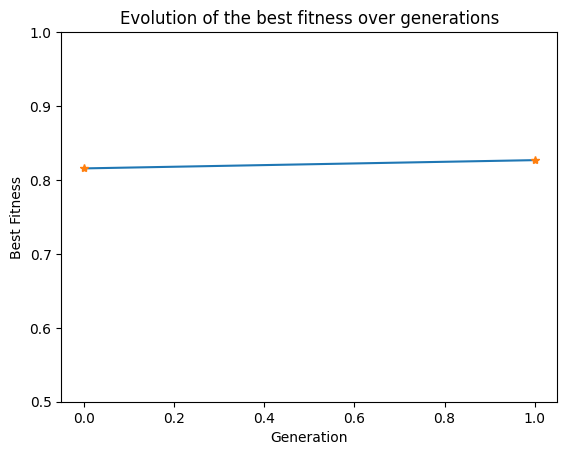

In [17]:
best_global_fitness = [best[1] for best in best_global]
plt.plot(best_global_fitness)
plt.plot(best_global_fitness, '*')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Evolution of the best fitness over generations')
plt.ylim(0.5, 1)
plt.show()

# Grid Search Comparation

In [22]:
import itertools

class GridSearchOptimizer:
    def __init__(self, param_grid):
        self.param_grid = param_grid
        self.best_params = None
        self.best_score = -np.inf  # Best score initialized to negative infinity

    def generate_grid(self):
        """Generate all combinations of hyperparameters from the grid."""
        return list(itertools.product(*self.param_grid.values()))

    def evaluate_combination(self, model_class, params):
        """Evaluate a single combination of hyperparameters."""
        model = model_class(params)
        model.load_data()
        model.build_model()
        model.train()
        score = model.evaluate()
        return score

    @measure_execution_time
    def run(self, model_class):
        """Run the grid search over the parameter grid."""
        param_combinations = self.generate_grid()
        params_len = len(param_combinations)
        for i, params in enumerate(param_combinations):
            params = {key: val for key, val in zip(self.param_grid.keys(), params)}
            print(f"Evaluating combination {i}/{params_len}: {params}")
            score = self.evaluate_combination(model_class, params)

            # Track best score and parameters
            if score > self.best_score:
                self.best_score = score
                self.best_params = params
            print(f"Score: {score} for parameters: {params}")

        print(f"Best params: {self.best_params} with score: {self.best_score}")
        return self.best_params

In [23]:
param_grid = {
    'learning_rate': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    'num_layers': list(range(1, 5 + 1)),
    'neurons_per_layer': [32, 64, 128, 256, 512],
    'batch_size': [16, 32, 64, 128],
    'dropout': list(np.arange(0, 0.5, 0.1)),
}

grid_search_optimizer = GridSearchOptimizer(param_grid)
best_hyperparameters = grid_search_optimizer.run(Model)

Evaluating combination 0/3000: {'learning_rate': 1e-06, 'num_layers': 1, 'neurons_per_layer': 32, 'batch_size': 16, 'dropout': np.float64(0.0)}
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5079 - loss: 0.8572 - val_accuracy: 0.5531 - val_loss: 0.9096
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5198 - loss: 0.8591 - val_accuracy: 0.5531 - val_loss: 0.9093
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5186 - loss: 0.8581 - val_accuracy: 0.5531 - val_loss: 0.9090
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5040 - loss: 0.8581 - val_accuracy: 0.5531 - val_loss: 0.9088
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4961 - loss: 0.8501 - val_accuracy: 0.5531 - val_loss: 0.9085
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4801 - loss: 0.8874 - val_accuracy: 0.5587 - val_loss: 0.9082
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4898 - loss: 0.8511 - val_acc

KeyboardInterrupt: 